# Step1: Load Model and Fig

In [ ]:
import torch, requests
from PIL import Image
from transformers import (
    AutoTokenizer,         
    AutoImageProcessor,    
    LlavaProcessor,        
    LlavaForConditionalGeneration,
    TextStreamer,
)
 
model_id = "llava-hf/llava-1.5-7b-hf"
tokenizer        = AutoTokenizer.from_pretrained(model_id, use_fast=False)
image_processor  = AutoImageProcessor.from_pretrained(model_id)
processor        = LlavaProcessor(image_processor=image_processor,
                                  tokenizer=tokenizer)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="cuda",            
)

url     = ("https://huggingface.co/datasets/huggingface/"
           "documentation-images/resolve/"
           "0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg")
image   = Image.open(requests.get(url, stream=True).raw)
question = "What color clothes is the rabbit wearing?"

prompt = f"USER: <image>\n{question} ASSISTANT:"

inputs = processor(images=image,
                   text=prompt,
                   return_tensors="pt",
                   padding=True).to(0, torch.float16)

print(f"Question：{question}")
print("\nOutput：")
streamer = TextStreamer(tokenizer=tokenizer,
                        skip_prompt=True,
                        skip_special_tokens=True)
model.generate(**inputs,
               max_new_tokens=200,
               do_sample=False,
               streamer=streamer)

In [1]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEV_GPU = torch.device('cuda:0')
DEV_CPU= torch.device('cpu')

import torch, requests
from PIL import Image
from transformers import (
    AutoTokenizer,         
    AutoImageProcessor,    
    LlavaProcessor,        
    LlavaForConditionalGeneration,
    TextStreamer,
)

model_id = "llava-hf/llava-1.5-7b-hf"

device = 0 if torch.cuda.is_available() else -1  # -1 indicates CPU
model =  LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="cuda"
)
 
# Load the processor
tokenizer        = AutoTokenizer.from_pretrained(model_id, use_fast=False)
image_processor  = AutoImageProcessor.from_pretrained(model_id)
processor        = LlavaProcessor(image_processor=image_processor,
                                  tokenizer=tokenizer)

/home/qw127/anaconda3/envs/corematching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/qw127/anaconda3/envs/corematching/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:09<00:00,  3.21s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


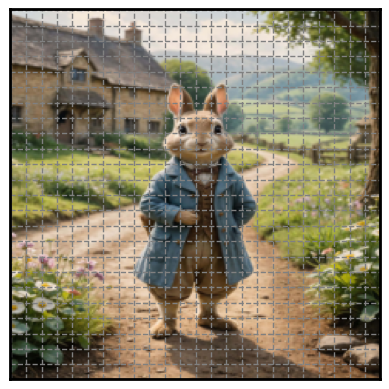

In [2]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
import numpy as np

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
response = requests.get(url, stream=True)
image = Image.open(response.raw)
image_24x24 = image.resize((240, 240), Image.BILINEAR)

image_array = np.array(image_24x24)

fig, ax = plt.subplots()

ax.imshow(image_array.astype(np.uint8))

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

major_ticks = np.arange(0, 240, 50)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


ax.tick_params(
    axis='both',        
    which='both',        
    labelbottom=False, 
    labelleft=False,
    length=0 
)


ax.set_xticks(np.arange(0, 240, 10), minor=True)
ax.set_yticks(np.arange(0, 240, 10), minor=True)
ax.grid(which="minor", color="gray", linestyle="--", linewidth=1)
ax.grid(which='major', color="gray", linestyle="--", linewidth=1)
# plt.savefig('fig/rabitte.pdf',bbox_inches='tight')

plt.show()

# Step2: Core Token (Neuron-based Metric)

## Step 2.1: Hook Activation

In [5]:
import torch
import re
model.cuda()
activation = []


def get_activation(name, activation_dict):
    def hook(model, input, output):
        activation_dict[name] = input[0].detach().to(DEV_CPU)
    return hook
 
def register_act_hooks(model, activation_dict):
    hooks = []
    for name, layer in model.language_model.named_modules():
        if "down_proj" in name:
            hooks.append(layer.register_forward_hook(get_activation(name, activation_dict)))
    return hooks


def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()



url     = ("https://huggingface.co/datasets/huggingface/"
           "documentation-images/resolve/"
           "0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg")
image   = Image.open(requests.get(url, stream=True).raw)
image = image.resize((256,256))
question = "What color clothes is the rabbit wearing?"

prompt = f"USER: <image>\n{question} ASSISTANT:"

inputs = processor(images=image,
                   text=prompt,
                   return_tensors="pt",
                   padding=True).to(0, torch.float16)


activation_dict = {}
hooks = register_act_hooks(model, activation_dict)

with torch.no_grad():
    outputs = model(**inputs)

activation.append(activation_dict)
remove_hooks(hooks)

## Step 2.2: Metric Calculation

In [6]:
import torch
act_atten_score=[]
for layer_num in range(32):
    str_act="model.layers."+str(layer_num)+".mlp.down_proj"
    tensor_A = activation[0][str_act].squeeze(0)
    
    binary_matrix = (tensor_A > 0.0).int()
    tensor_C = binary_matrix @ binary_matrix.T
    tensor_C = tensor_C.to(torch.int32)
    
    act_atten_score.append(tensor_C)

## Step 2.3: Visualization of the number of activated common neurons

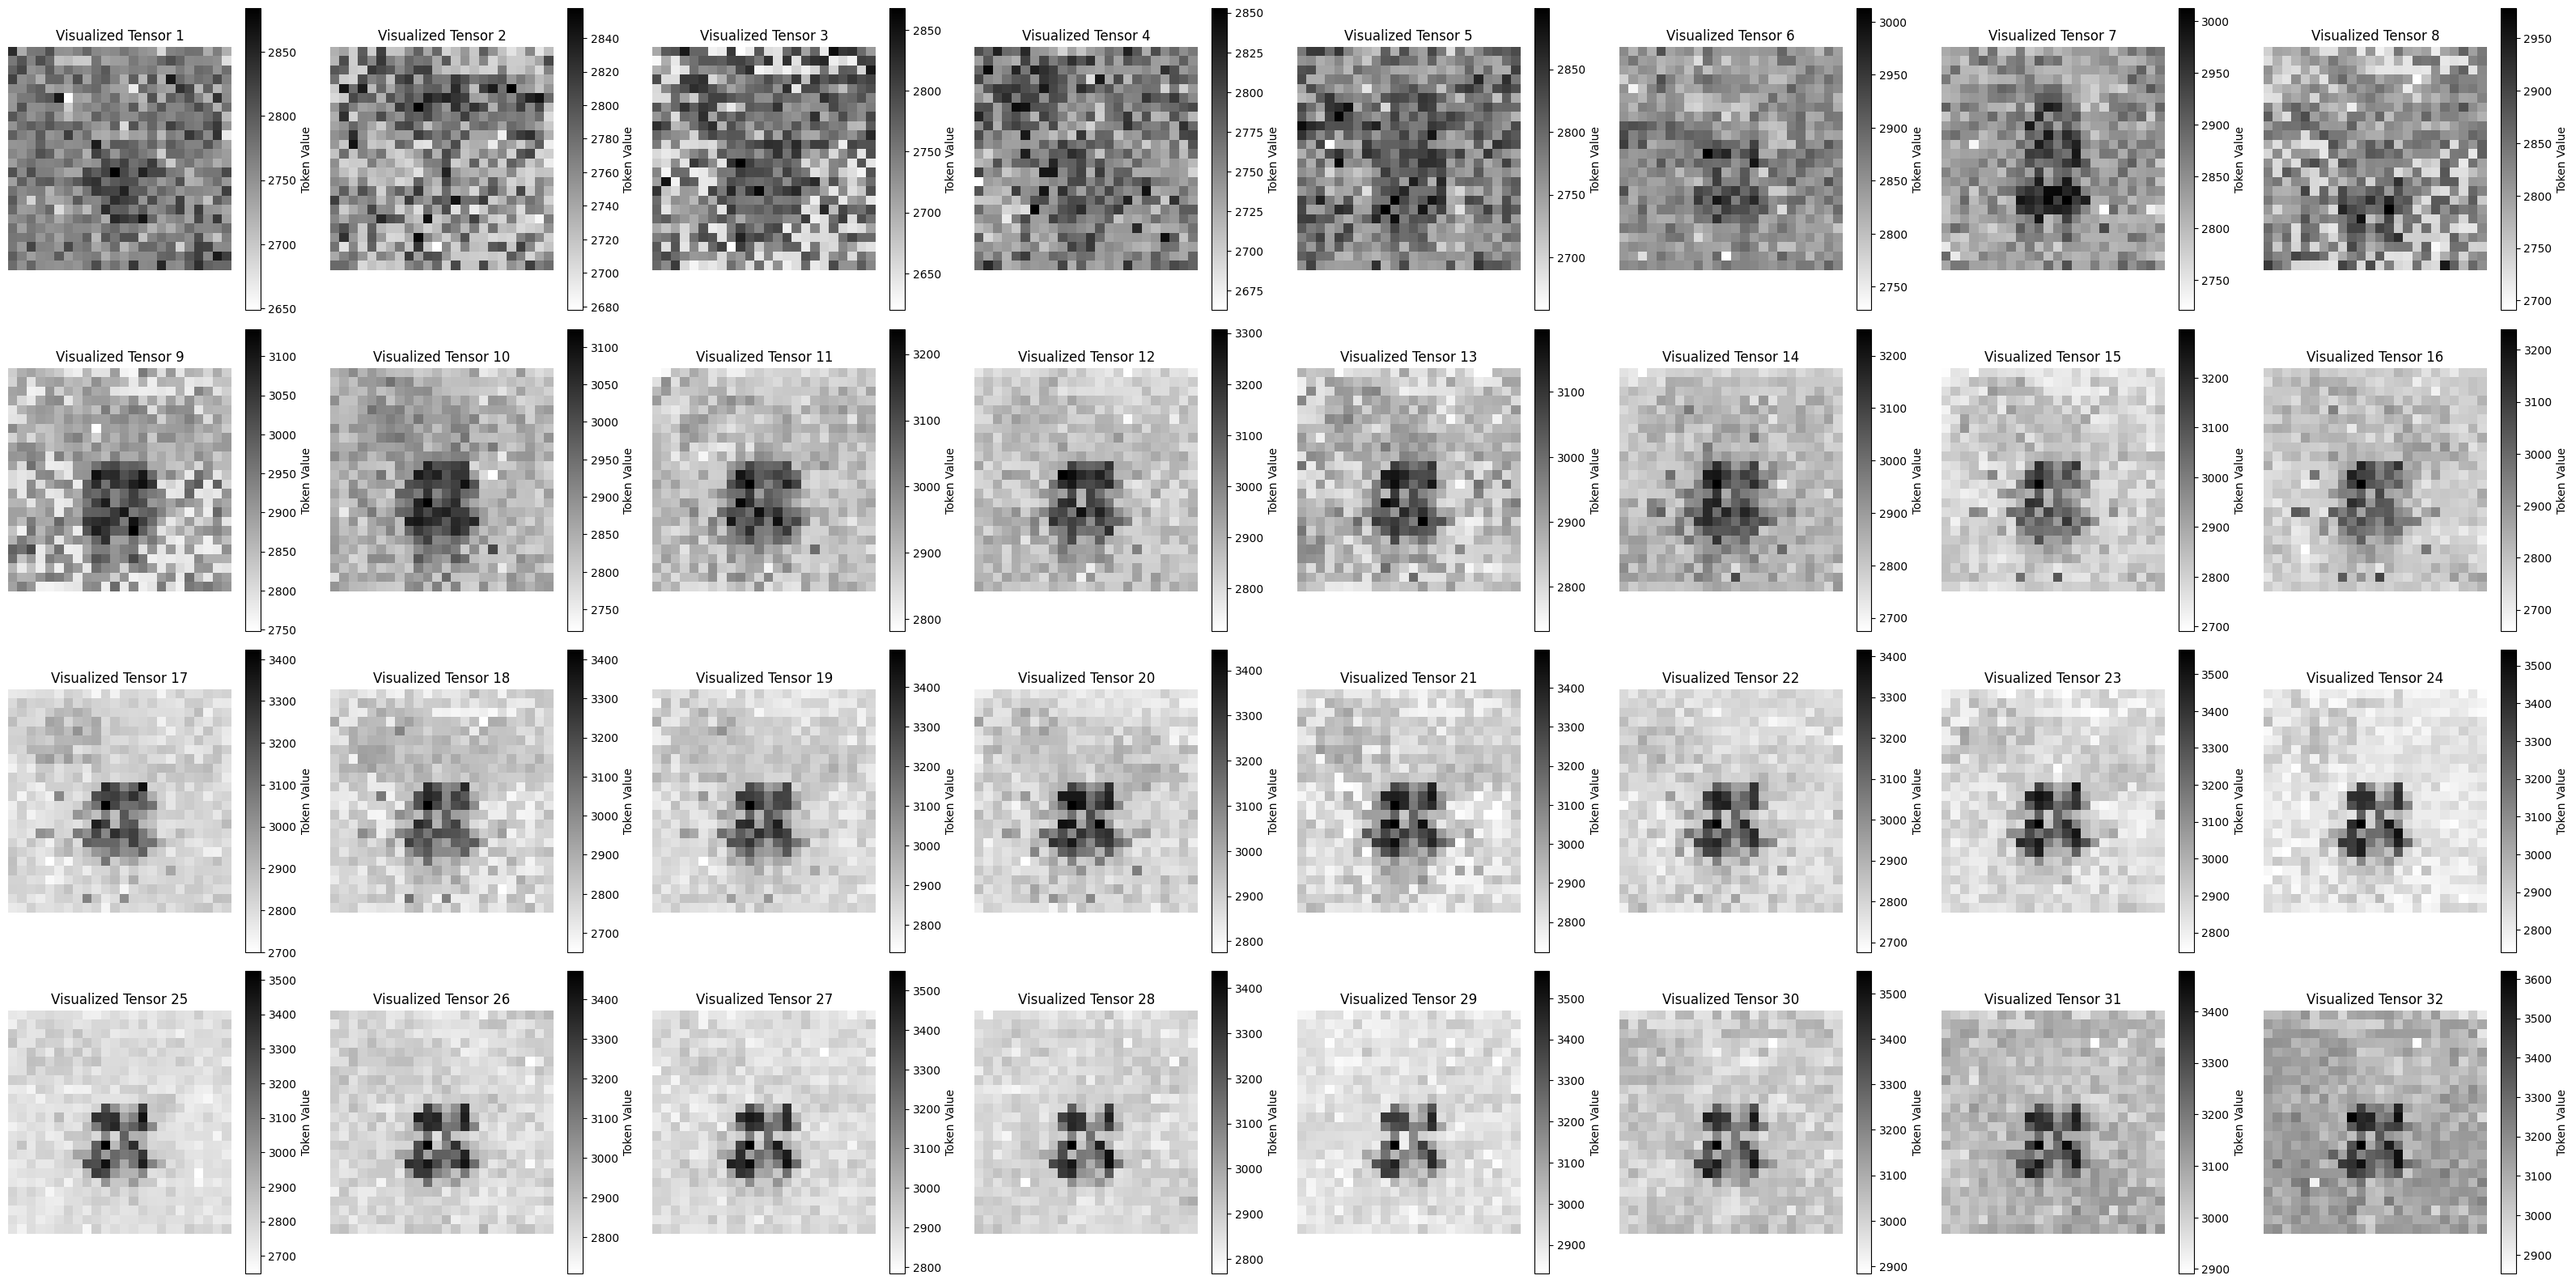

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize(tensor):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().numpy()
        
    assert tensor.size == 576, f"Expected tensor size to be 6404, but got{tensor.size}"
    combined_image = tensor.reshape(24, 24)
    combined_image = np.kron(combined_image, np.ones((1,1)))
    
    
    return combined_image



import matplotlib.pyplot as plt
import numpy as np

n_images = 32
n_cols = 8
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for idx in range(n_images):
    layer_0 = act_atten_score[idx][-5][5:581]
    combined_image = visualize(layer_0)
    ax = axes[idx]
    im = ax.imshow(combined_image, cmap='gray_r', interpolation='nearest')
    ax.set_title(f'Visualized Tensor {idx+1}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, label='Token Value')


for idx in range(n_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Step 2.4: Visualization of Core Token per Layer

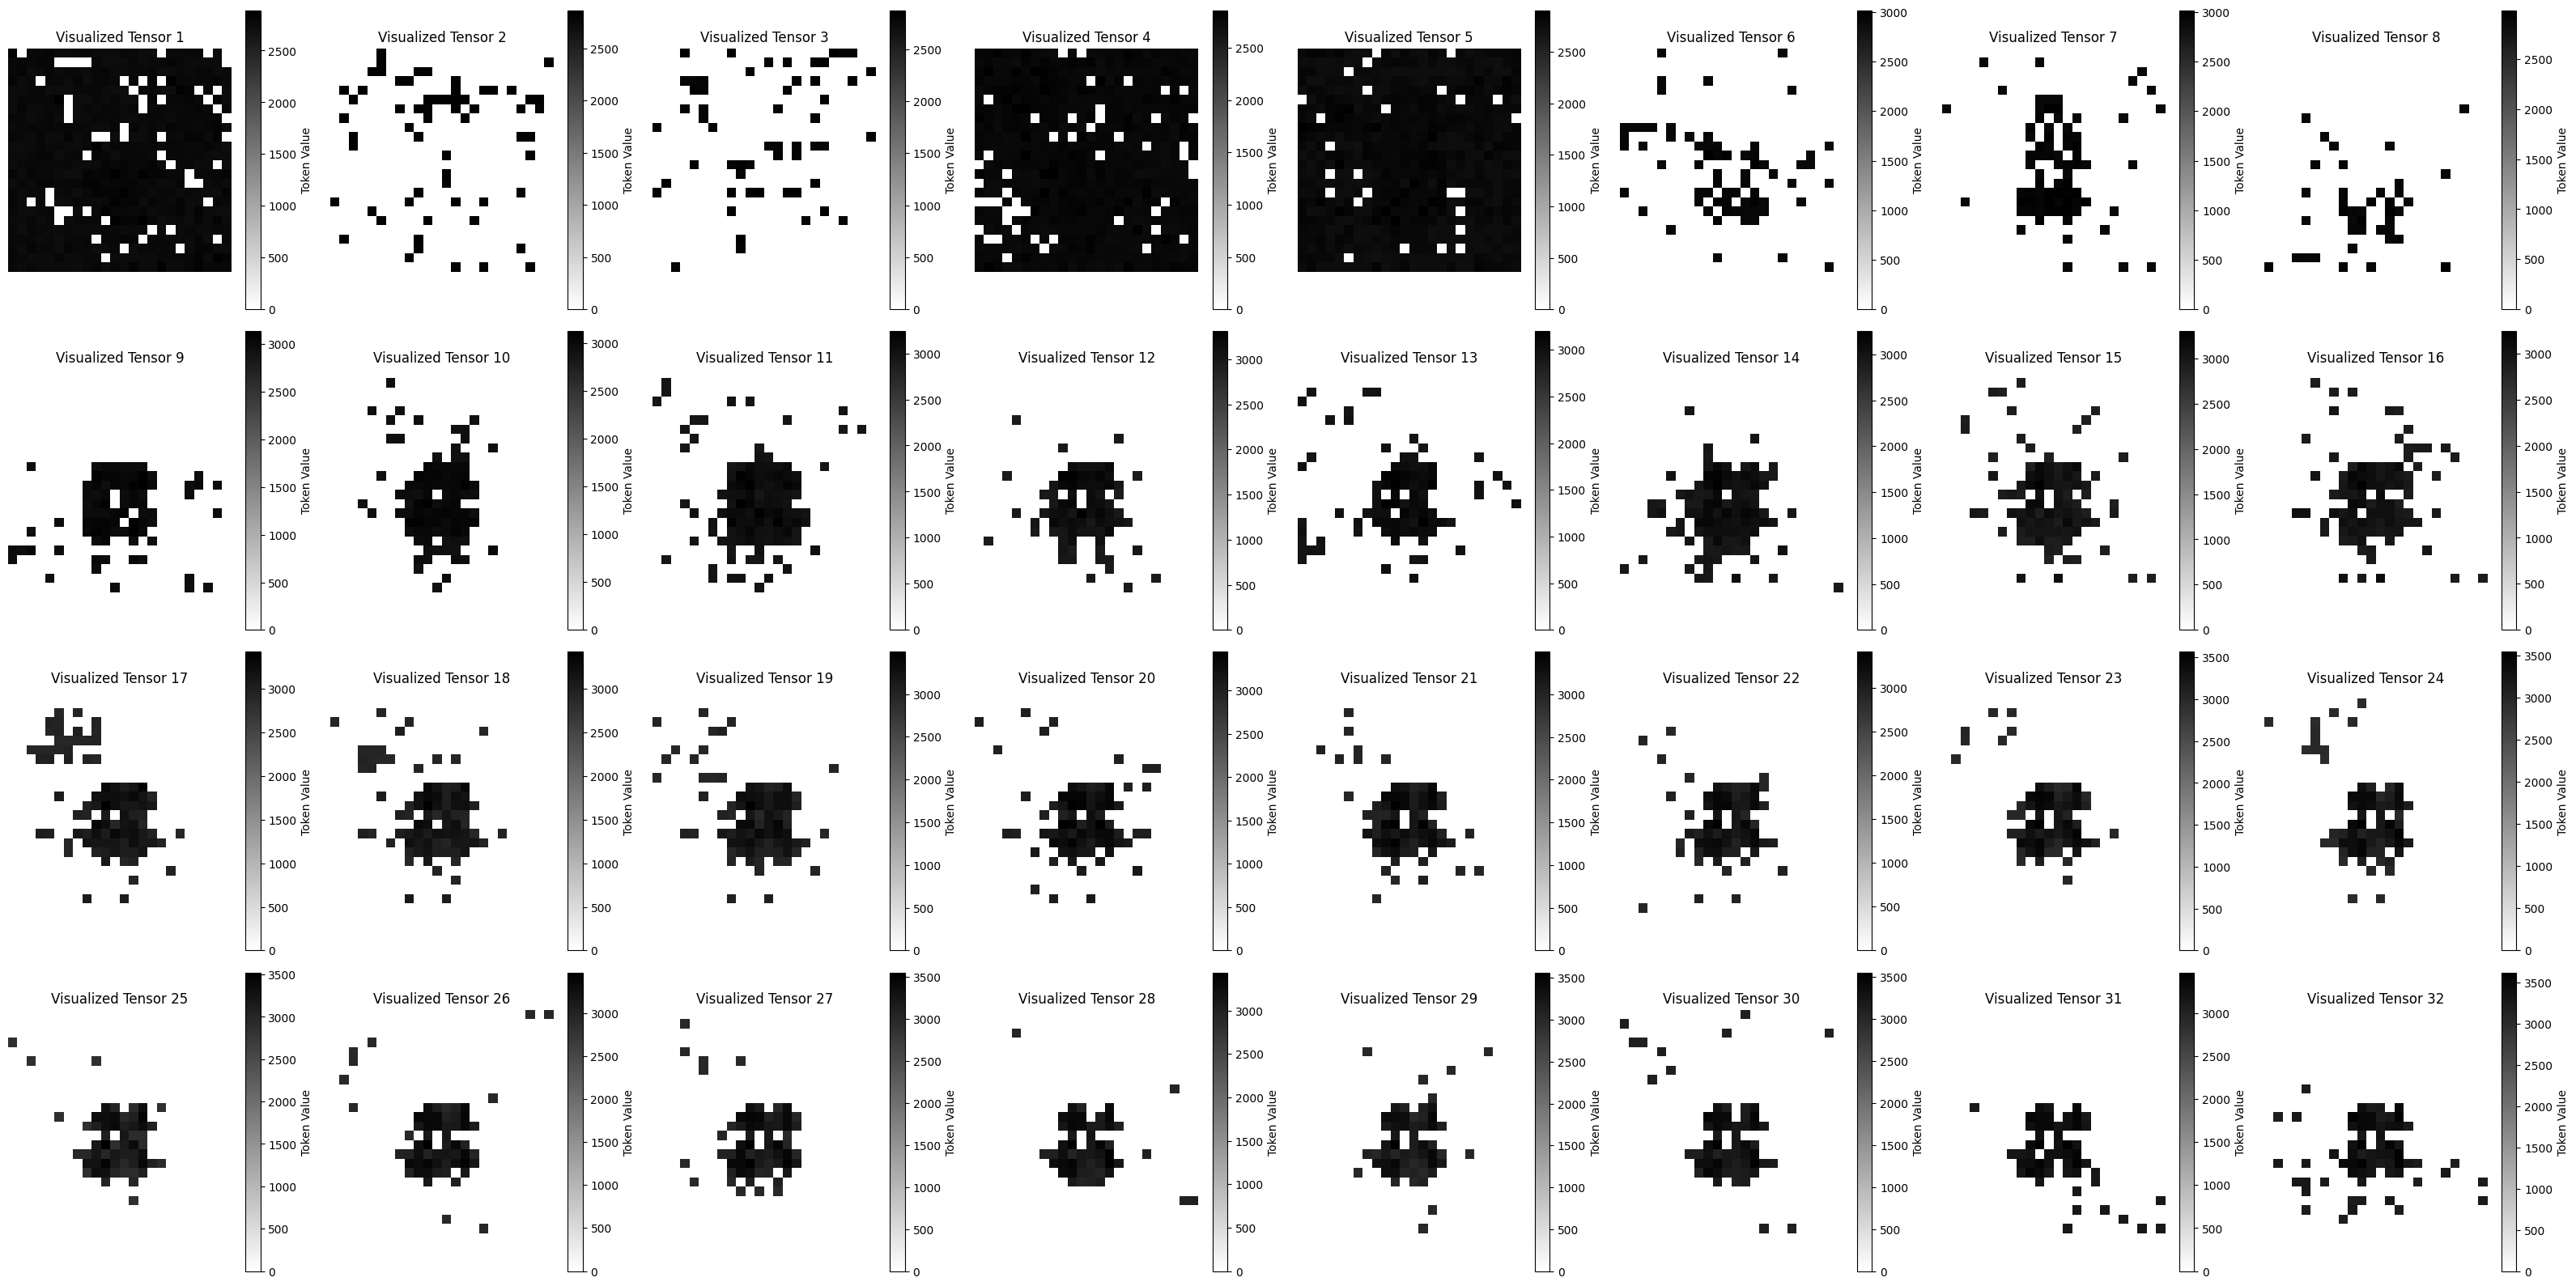

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize(tensor):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().numpy()
        
    assert tensor.size == 576, f"Expected tensor size to be 6404, but got{tensor.size}"
    combined_image = tensor.reshape(24, 24)
    combined_image = np.kron(combined_image, np.ones((1,1)))
    return combined_image



import matplotlib.pyplot as plt
import numpy as np



n_images = 32
n_cols = 8
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for idx in range(n_images):
    layer_0 = act_atten_score[idx][-5][5:581].clone().detach()
    
    sorted_data = torch.sort(layer_0, descending=True).values
    x = np.arange(len(sorted_data))  # 索引数组
    start_point = np.array([0, sorted_data[0].item()])
    end_point = np.array([len(sorted_data) - 1, sorted_data[-1].item()])
    line_vec = end_point - start_point
    line_vec = line_vec / np.linalg.norm(line_vec)
    point_vecs = np.vstack((x, sorted_data.numpy())).T - start_point
    projections = np.dot(point_vecs, line_vec)
    distances = np.linalg.norm(point_vecs - np.outer(projections, line_vec), axis=1)
    
    # 找到距离最大的点作为肘部
    elbow_index = np.argmax(distances)
    elbow_value = sorted_data[elbow_index].item()
    
    layer_0[layer_0 < elbow_value] = 0
    
    
    combined_image = visualize(layer_0)
    ax = axes[idx]
    im = ax.imshow(combined_image, cmap='gray_r', interpolation='nearest')
    ax.set_title(f'Visualized Tensor {idx+1}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, label='Token Value')


for idx in range(n_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [9]:
idx=10 #17 #27
layer_0 = act_atten_score[idx][-5][5:581].clone().detach()
sorted_data = torch.sort(layer_0, descending=True).values
x = np.arange(len(sorted_data))  # 索引数组
start_point = np.array([0, sorted_data[0].item()])
end_point = np.array([len(sorted_data) - 1, sorted_data[-1].item()])
line_vec = end_point - start_point
line_vec = line_vec / np.linalg.norm(line_vec)
point_vecs = np.vstack((x, sorted_data.numpy())).T - start_point
projections = np.dot(point_vecs, line_vec)
distances = np.linalg.norm(point_vecs - np.outer(projections, line_vec), axis=1)

# 找到距离最大的点作为肘部
elbow_index = np.argmax(distances)
elbow_value = sorted_data[elbow_index].item()

layer_0[layer_0 < elbow_value] = 0

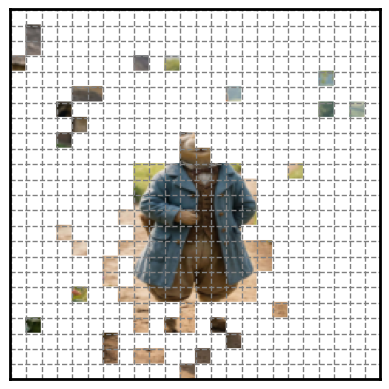

In [10]:
import matplotlib.pyplot as plt
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_24x24 = image.resize((240, 240), Image.BILINEAR)

image_array = np.array(image_24x24)
layer_expand = layer_0.reshape(24, 24).repeat_interleave(10, dim=0).repeat_interleave(10, dim=1)
mask = layer_expand.numpy() > 0

# Create a white background
output_image = np.ones_like(image_24x24) * 255

# Copy only the non-zero parts of the image
if image_array.ndim == 3:  # For RGB images
    output_image[mask] = image_array[mask]
else:  # For grayscale images
    output_image[mask] = image_array[mask]

fig, ax = plt.subplots()
# Display the result
ax.imshow(output_image.astype(np.uint8))
# ax.axis('off')

# Add a border to the figure
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Add a grid with interval of 1
ax.set_xticks(np.arange(0, 240, 10), minor=True)
ax.set_yticks(np.arange(0, 240, 10), minor=True)
# 隐藏刻度标签
ax.tick_params(
    axis='both',          # 应用于x轴和y轴
    which='both',         # 应用于主刻度和次刻度
    labelbottom=False,    # 隐藏x轴刻度标签
    labelleft=False,      # 隐藏y轴刻度标签
    length=0              # 移除刻度线
)
ax.grid(which="minor", color="gray", linestyle="--", linewidth=1)
ax.grid(which='major', color="gray", linestyle="--", linewidth=1)
# plt.savefig('rabitte_road.pdf',bbox_inches='tight')
plt.show()